# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [10]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [11]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow.keras as tfk

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [12]:
%%capture
pip install -U albumentations

## ⏳ Load the Data

In [13]:
data = np.load("mars_for_students_cleaned.npz")
data2 = np.load("mars_cleaned_and_augmented.npz")

print("Keys in the data dictionary:")
print(data.files)
training_set = data["training_set"]
X_train = training_set[:, 0, :, :]
y_train = training_set[:, 1, :, :]


X_test = data["test_set"]

print(f"training set shape: {data['training_set'].shape}")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Keys in the data dictionary:
['training_set', 'test_set']
training set shape: (2505, 2, 64, 128)
Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [14]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 0.01

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 500

# Set data split size for training and validation
SPLITS_SIZE = 300

NUM_CLASSES = 5

class_labels = {
	0: "Background",
	1: "Soil",
	2: "Bedrock",
	3: "Sand",
	4: "Big Rock"
}

In [15]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [16]:
y_train = y_train[..., np.newaxis]

print(y_train.shape)

(2505, 64, 128, 1)


In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

def display_image_and_mask(image, mask):
  """Displays an image and its corresponding mask side-by-side.

  Args:
    image: The input image as a NumPy array.
    mask: The corresponding mask as a NumPy array.
  """

  plt.figure(figsize=(10, 5))

  plt.subplot(121)
  plt.imshow(image, cmap="gray")
  plt.title("Input image")

  plt.subplot(122)
  plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
  plt.title("Target image")



def display_random_images_and_masks(images, masks, num_images=5):
  """Displays a specified number of random images and their masks.

  Args:
    images: The input images as a NumPy array.
    masks: The corresponding masks as a NumPy array.
    num_images: The number of images to display (default is 5).
  """

  # Generate random indices for image selection
  random_indices = random.sample(range(len(images)), num_images)

  # Display images and masks for selected indices
  for index in random_indices:
    image = images[index]
    mask = masks[index]

    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.title("Input image")

    plt.subplot(122)
    plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
    plt.title("Target image")

    plt.show()

In [20]:
# separate in train val test
from sklearn.model_selection import train_test_split

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=SEED
)


X_train2 = data2['X_train']
y_train2 = data2['y_train']

#add one dim to y_train_2
y_train2 = y_train2[..., np.newaxis]

print(f"Train set shape: {train_img.shape}")
print(f"Validation set shape: {val_img.shape}")

train_img = np.concatenate((train_img, X_train2), axis=0)
train_lbl = np.concatenate((train_lbl, y_train2), axis=0)

print(f"Train set shape: {train_img.shape}")
print(f"Validation set shape: {val_img.shape}")
print(f"Test set shape: {test_img.shape}")

Train set shape: (1905, 64, 128, 1)
Validation set shape: (300, 64, 128, 1)
Train set shape: (7122, 64, 128, 1)
Validation set shape: (300, 64, 128, 1)
Test set shape: (300, 64, 128, 1)


In [21]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [22]:
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label




In [23]:
from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    # dataset = dataset.map(
    #     lambda x, y: (x, apply_category_mapping(y)),
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    if augment:

        augmentations = A.Compose([
            #A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Flip(),
            # A.Transpose(),
            #A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                #A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
            A.RandomGridShuffle(grid = (3,3), always_apply=False, p = 0.3),
            A.RandomBrightnessContrast(brightness_limit = 0.2,
                                        contrast_limit = 0.2,
                                        always_apply = False,
                                        p = 0.2
                                      ),
            #A.Sharpen(alpha=(0.2, 0.5), lightness = (0.5, 1.0), always_apply=False, p = 0.5),
            A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
            # A.RandomCrop(height=64, width=128, p=1),
            # A.OneOf([
            #     #A.CLAHE(clip_limit=2),
            #     A.RandomBrightnessContrast(),
            # ], p=0.3),
            # A.HueSaturationValue(p=0.3),
        ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Creating datasets...


<ipython-input-23-62be4001c797>:58: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-23-62be4001c797>:58: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-23-62be4001c797>:58: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-23-62be4001c797>:58: UserWarning: Argument 'fill_value' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-23-62be4001c797>:58: UserWarning: Argument 'mask_fill_value' is no

WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float32'>


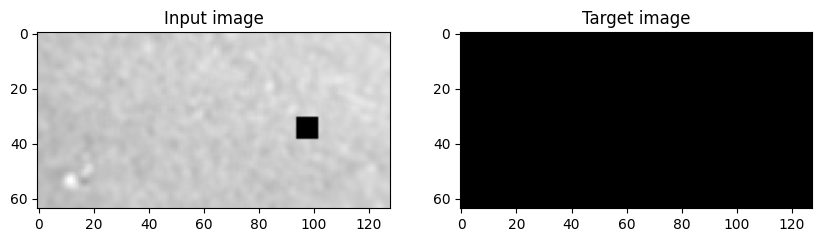

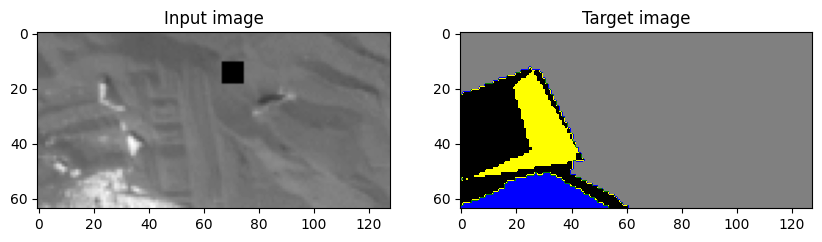

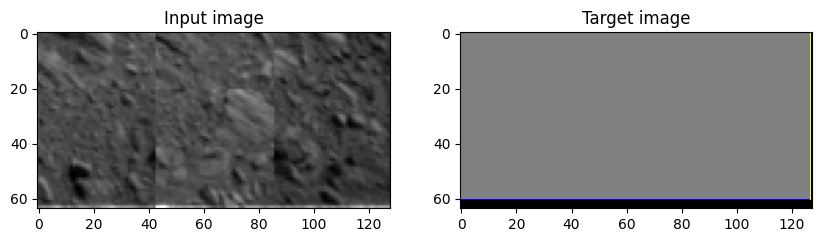

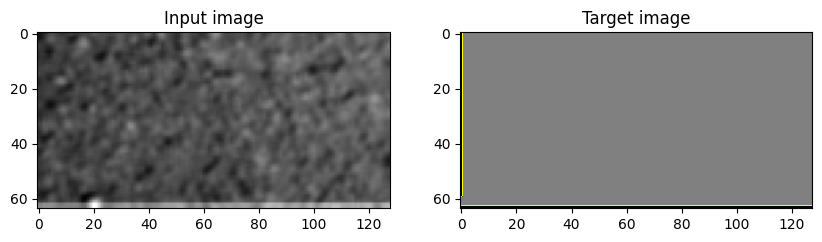

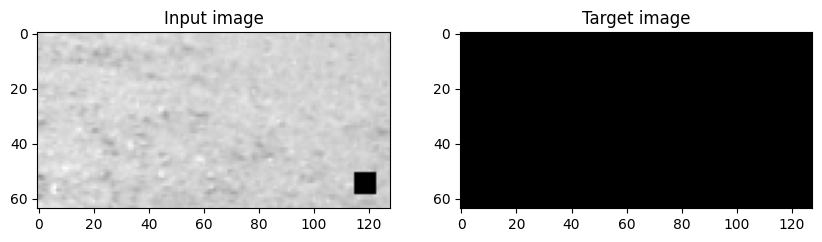

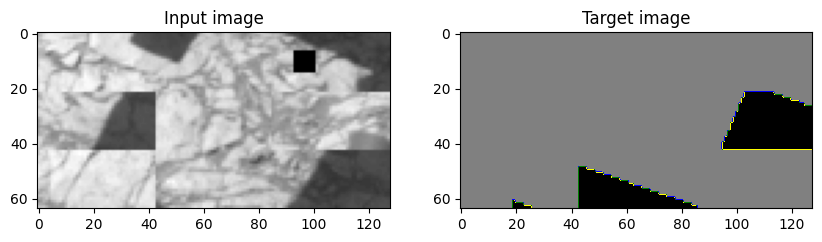

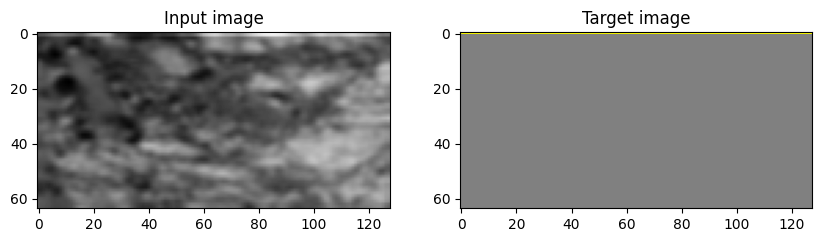

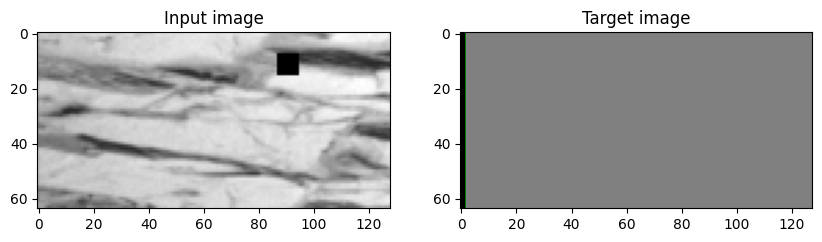

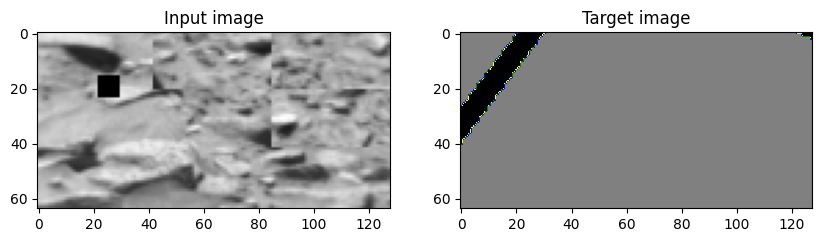

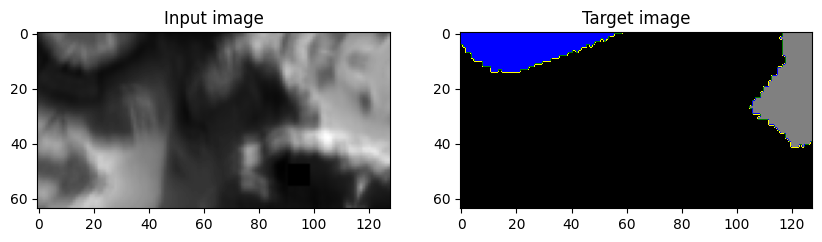

In [24]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    display_random_images_and_masks(images, labels, num_images=10)
    break

## 🛠️ Train and Save the Model

In [25]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tfkl.Lambda(lambda x, repnum: tfk.backend.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation('relu')(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    shortcut = tfkl.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = tfkl.BatchNormalization(axis=3)(shortcut)

    res_path = tfkl.add([shortcut, conv])
    res_path = tfkl.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tfkl.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = tfk.backend.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tfkl.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tfkl.add([upsample_g, theta_x])
    act_xg = tfkl.Activation('relu')(concat_xg)
    psi = tfkl.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tfkl.Activation('sigmoid')(psi)
    shape_sigmoid = tfk.backend.int_shape(sigmoid_xg)
    upsample_psi = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = tfkl.multiply([upsample_psi, x])

    result = tfkl.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tfkl.BatchNormalization()(result)
    return result_bn


In [26]:
def Attention_ResUNet(input_shape=(64, 128, 1), NUM_CLASSES=NUM_CLASSES, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = tfkl.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = tfkl.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = tfkl.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = tfkl.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = tfkl.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = tfkl.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = tfkl.BatchNormalization(axis=axis)(conv_final)
    conv_final = tfkl.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = tfk.models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


Model: "AttentionResUNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 32)  │          128 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 32)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 64, 128, 32)  │           64 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 32)  │        9,248 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 64, 128, 32)  │          128 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 32)  │          128 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 64, 128, 32)  │            0 │ batch_normalizatio… │    -    │
│                        │                      │              │ batch_normalizatio… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 32)  │            0 │ add[0][0]           │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ activation_1[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 32, 64, 64)   │          256 │ conv2d_3[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_2           │ (None, 32, 64, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_5 (Conv2D)    

 Total params: 9,787,005 (37.33 MB)

 Trainable params: 9,776,243 (37.29 MB)

 Non-trainable params: 10,762 (42.04 KB)

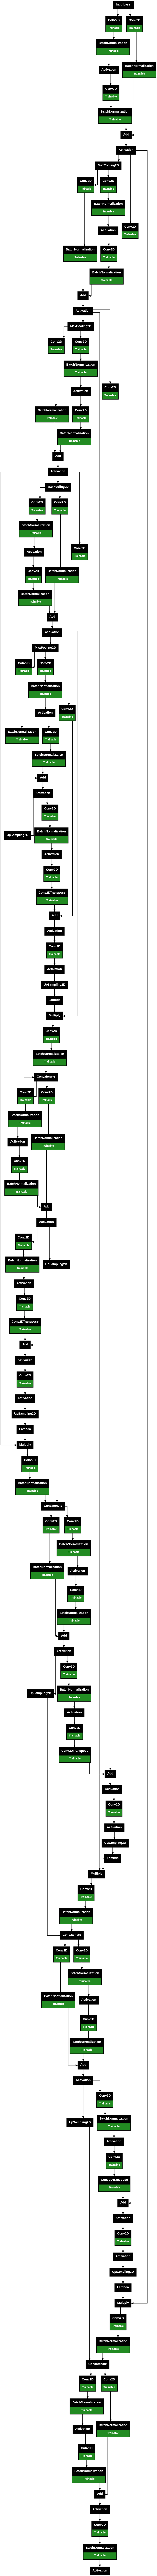

In [27]:
model = Attention_ResUNet()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)


In [28]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=( 64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


In [29]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [30]:
from keras import backend as K


def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    # There is no tf.pi so we wrap np.pi as a TF constant
    learning_rate = 0.5 * target_lr * (
    1 + tf.cos(
        tf.constant(np.pi, dtype=tf.float32) *
        (tf.cast(global_step, tf.float32) - tf.cast(warmup_steps, tf.float32) - tf.cast(hold, tf.float32)) /
        float(total_steps - warmup_steps - hold)
    )
    )


    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = tf.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = tf.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(tfk.optimizers.schedules.LearningRateSchedule):
    def __init__(self, start_lr, target_lr, warmup_steps, total_steps, hold):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(global_step=step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)

        return tf.where(
            step > self.total_steps, 0.0, lr, name="learning_rate"
        )

In [31]:
# Compile the model
from tensorflow.keras.optimizers.schedules import ExponentialDecay


# If batched
total_steps = len(train_dataset)*EPOCHS
warmup_steps = int(0.08*total_steps)

lr_schedule = WarmUpCosineDecay(start_lr=0.0, target_lr=0.1, warmup_steps=warmup_steps, total_steps=total_steps, hold=warmup_steps)

print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=0),
    optimizer=tf.keras.optimizers.AdamW(lr_schedule),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [32]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=50,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

reduceOnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_mean_iou",
    factor=0.1,
    patience=40
)

Epoch 1/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.3602 - loss: 1.5015 - mean_iou: 0.2036

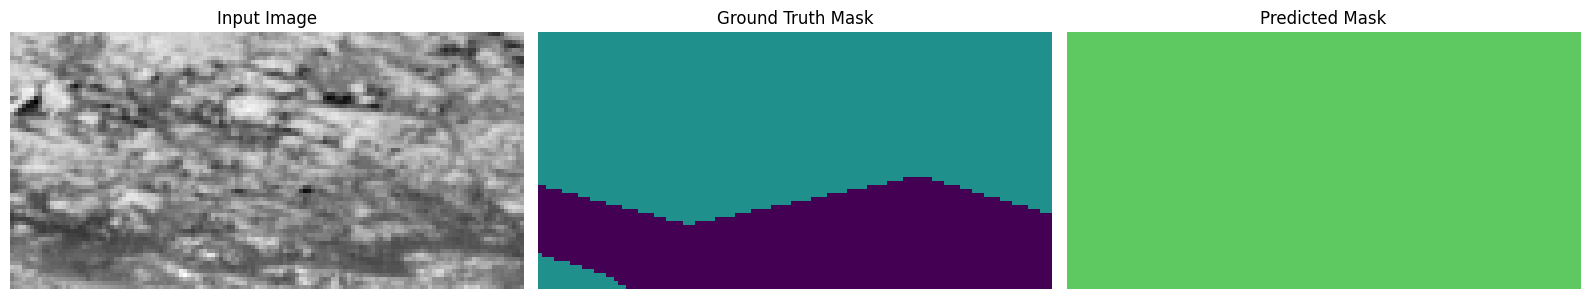

112/112 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.3606 - loss: 1.5010 - mean_iou: 0.2042 - val_accuracy: 0.1807 - val_loss: 1.6769 - val_mean_iou: 0.0598
Epoch 2/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 393ms/step - accuracy: 0.4760 - loss: 1.3895 - mean_iou: 0.2918 - val_accuracy: 0.2166 - val_loss: 1.6091 - val_mean_iou: 0.0907
Epoch 3/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 386ms/step - accuracy: 0.4851 - loss: 1.3208 - mean_iou: 0.2998 - val_accuracy: 0.3711 - val_loss: 1.4375 - val_mean_iou: 0.1836
Epoch 4/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 381ms/step - accuracy: 0.5247 - loss: 1.2315 - mean_iou: 0.3386 - val_accuracy: 0.3725 - val_loss: 1.3351 - val_mean_iou: 0.1764
Epoch 5/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 383ms/step - accuracy: 0.5199 - loss: 1.1954 - mean_iou: 0.3432 - val_accuracy: 0.4367 - val_loss: 1.3095 - val_mean_iou: 0.2445
Epoch 6/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.5331 - loss: 1.1607 - mean_iou: 0.3626

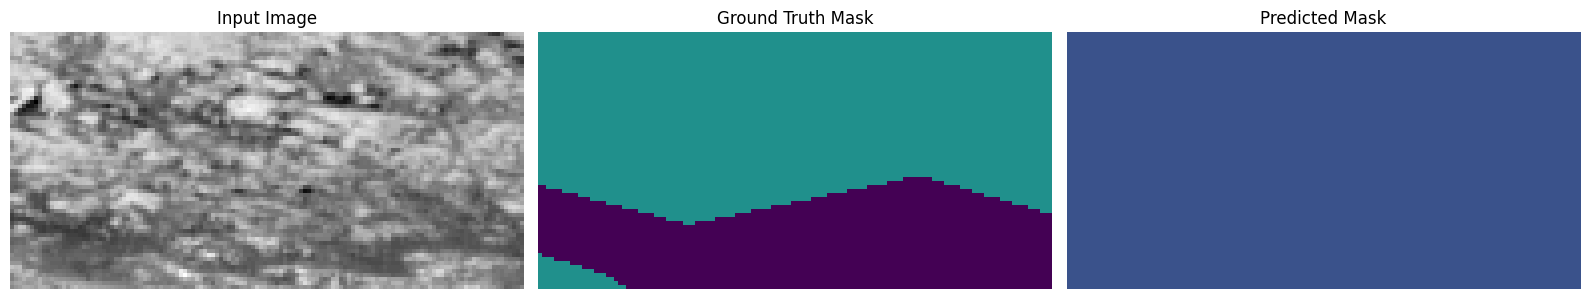

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 387ms/step - accuracy: 0.5327 - loss: 1.1606 - mean_iou: 0.3628 - val_accuracy: 0.4396 - val_loss: 1.3102 - val_mean_iou: 0.2884
Epoch 7/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 387ms/step - accuracy: 0.5204 - loss: 1.1612 - mean_iou: 0.3465 - val_accuracy: 0.3976 - val_loss: 1.2732 - val_mean_iou: 0.2115
Epoch 8/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 390ms/step - accuracy: 0.5353 - loss: 1.1364 - mean_iou: 0.3661 - val_accuracy: 0.3769 - val_loss: 1.3291 - val_mean_iou: 0.2066
Epoch 9/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 389ms/step - accuracy: 0.5467 - loss: 1.1175 - mean_iou: 0.3838 - val_accuracy: 0.5194 - val_loss: 1.1628 - val_mean_iou: 0.3307
Epoch 10/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 388ms/step - accuracy: 0.5365 - loss: 1.1248 - mean_iou: 0.3690 - val_accuracy: 0.4755 - val_loss: 1.2295 - val_mean_iou: 0.3284
Epoch 11/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5399 - loss: 1.1183 - mean_iou: 0.3716

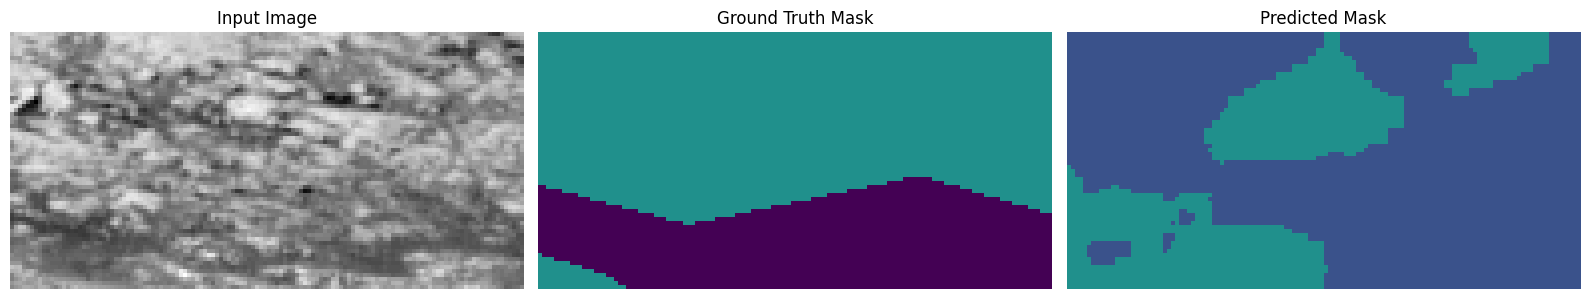

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 392ms/step - accuracy: 0.5395 - loss: 1.1183 - mean_iou: 0.3718 - val_accuracy: 0.5380 - val_loss: 1.1671 - val_mean_iou: 0.3450
Epoch 12/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 390ms/step - accuracy: 0.5544 - loss: 1.1014 - mean_iou: 0.3927 - val_accuracy: 0.3880 - val_loss: 1.3201 - val_mean_iou: 0.1692
Epoch 13/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 390ms/step - accuracy: 0.5437 - loss: 1.1106 - mean_iou: 0.3826 - val_accuracy: 0.4371 - val_loss: 1.2825 - val_mean_iou: 0.2427
Epoch 14/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 387ms/step - accuracy: 0.5603 - loss: 1.0898 - mean_iou: 0.4061 - val_accuracy: 0.5877 - val_loss: 1.0889 - val_mean_iou: 0.4870
Epoch 15/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 391ms/step - accuracy: 0.5465 - loss: 1.1035 - mean_iou: 0.3842 - val_accuracy: 0.5449 - val_loss: 1.1424 - val_mean_iou: 0.3503
Epoch 16/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5611 - loss: 1.0893 - mean_iou: 0.4010

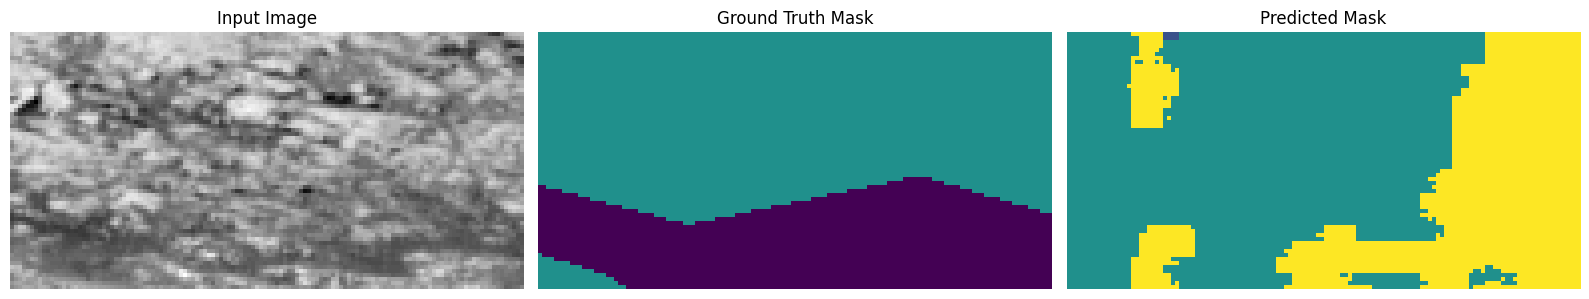

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 390ms/step - accuracy: 0.5606 - loss: 1.0893 - mean_iou: 0.4014 - val_accuracy: 0.2909 - val_loss: 1.4010 - val_mean_iou: 0.2029
Epoch 17/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 386ms/step - accuracy: 0.5594 - loss: 1.0836 - mean_iou: 0.4115 - val_accuracy: 0.4658 - val_loss: 1.2431 - val_mean_iou: 0.3423
Epoch 18/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 384ms/step - accuracy: 0.5615 - loss: 1.0866 - mean_iou: 0.4176 - val_accuracy: 0.4533 - val_loss: 1.2193 - val_mean_iou: 0.3315
Epoch 19/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 385ms/step - accuracy: 0.5664 - loss: 1.0779 - mean_iou: 0.4249 - val_accuracy: 0.0204 - val_loss: 1.8270 - val_mean_iou: 0.0201
Epoch 20/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 84s 405ms/step - accuracy: 0.5685 - loss: 1.0759 - mean_iou: 0.4649 - val_accuracy: 0.4463 - val_loss: 1.2574 - val_mean_iou: 0.3238
Epoch 21/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5650 - loss: 1.0812 - mean_iou: 0.5299

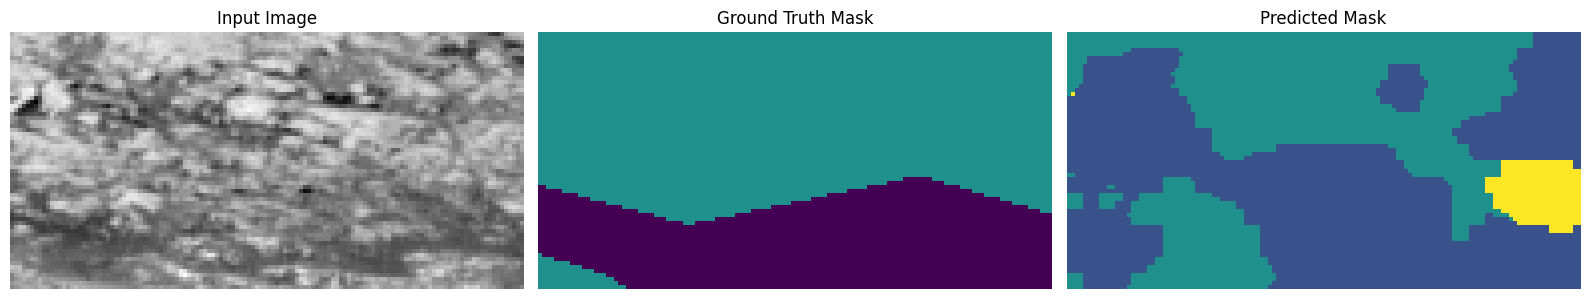

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 408ms/step - accuracy: 0.5646 - loss: 1.0811 - mean_iou: 0.5306 - val_accuracy: 0.5056 - val_loss: 1.1844 - val_mean_iou: 0.4002
Epoch 22/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 79s 384ms/step - accuracy: 0.5668 - loss: 1.0768 - mean_iou: 0.5299 - val_accuracy: 0.3796 - val_loss: 1.3002 - val_mean_iou: 0.2476
Epoch 23/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 387ms/step - accuracy: 0.5655 - loss: 1.0758 - mean_iou: 0.5285 - val_accuracy: 0.5469 - val_loss: 1.1321 - val_mean_iou: 0.4418
Epoch 24/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 385ms/step - accuracy: 0.5621 - loss: 1.0802 - mean_iou: 0.5317 - val_accuracy: 0.5594 - val_loss: 1.1184 - val_mean_iou: 0.4563
Epoch 25/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 386ms/step - accuracy: 0.5672 - loss: 1.0732 - mean_iou: 0.5455 - val_accuracy: 0.3666 - val_loss: 1.3152 - val_mean_iou: 0.2546
Epoch 26/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5678 - loss: 1.0769 - mean_iou: 0.5420

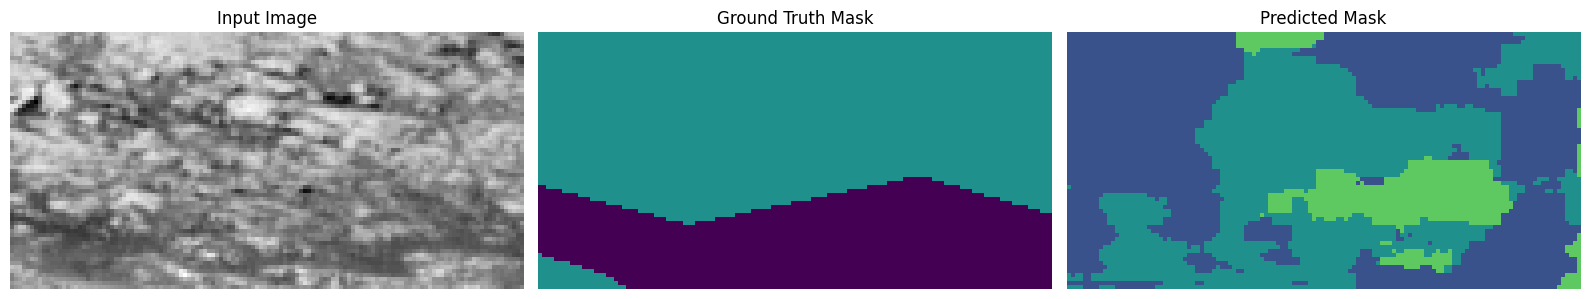

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 389ms/step - accuracy: 0.5674 - loss: 1.0768 - mean_iou: 0.5427 - val_accuracy: 0.4850 - val_loss: 1.1735 - val_mean_iou: 0.3499
Epoch 27/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 392ms/step - accuracy: 0.5746 - loss: 1.0688 - mean_iou: 0.5526 - val_accuracy: 0.5637 - val_loss: 1.1131 - val_mean_iou: 0.4704
Epoch 28/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 389ms/step - accuracy: 0.5740 - loss: 1.0663 - mean_iou: 0.5544 - val_accuracy: 0.5766 - val_loss: 1.1067 - val_mean_iou: 0.4795
Epoch 29/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 385ms/step - accuracy: 0.5693 - loss: 1.0703 - mean_iou: 0.5498 - val_accuracy: 0.4338 - val_loss: 1.2721 - val_mean_iou: 0.3196
Epoch 30/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 391ms/step - accuracy: 0.5764 - loss: 1.0656 - mean_iou: 0.5568 - val_accuracy: 0.3898 - val_loss: 1.3235 - val_mean_iou: 0.2698
Epoch 31/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5580 - loss: 1.0872 - mean_iou: 0.5225

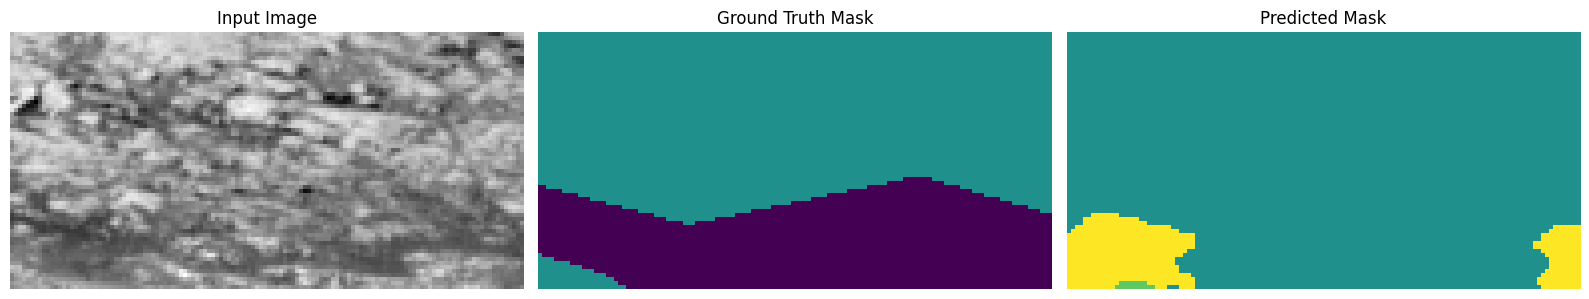

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 390ms/step - accuracy: 0.5577 - loss: 1.0870 - mean_iou: 0.5233 - val_accuracy: 0.3340 - val_loss: 1.3839 - val_mean_iou: 0.2377
Epoch 32/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 386ms/step - accuracy: 0.5804 - loss: 1.0627 - mean_iou: 0.5668 - val_accuracy: 0.3770 - val_loss: 1.2801 - val_mean_iou: 0.1922
Epoch 33/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 383ms/step - accuracy: 0.5754 - loss: 1.0648 - mean_iou: 0.5626 - val_accuracy: 0.5279 - val_loss: 1.1505 - val_mean_iou: 0.4160
Epoch 34/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 383ms/step - accuracy: 0.5670 - loss: 1.0749 - mean_iou: 0.5448 - val_accuracy: 0.4958 - val_loss: 1.2087 - val_mean_iou: 0.3639
Epoch 35/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 380ms/step - accuracy: 0.5661 - loss: 1.0767 - mean_iou: 0.5366 - val_accuracy: 0.4847 - val_loss: 1.2111 - val_mean_iou: 0.3543
Epoch 36/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5753 - loss: 1.0686 - mean_iou: 0.5557

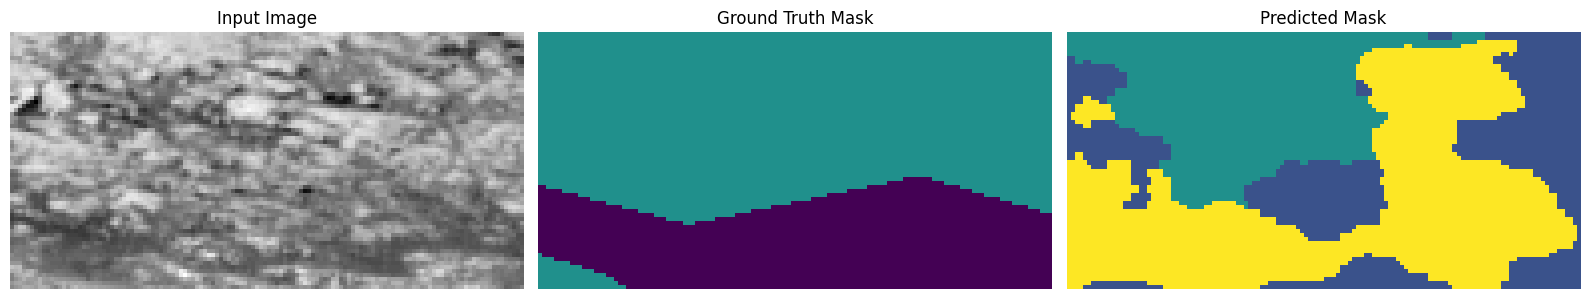

112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 387ms/step - accuracy: 0.5749 - loss: 1.0685 - mean_iou: 0.5565 - val_accuracy: 0.3820 - val_loss: 1.3578 - val_mean_iou: 0.3149
Epoch 37/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 381ms/step - accuracy: 0.5785 - loss: 1.0635 - mean_iou: 0.5678 - val_accuracy: 0.4738 - val_loss: 1.2531 - val_mean_iou: 0.3427
Epoch 38/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 379ms/step - accuracy: 0.5761 - loss: 1.0657 - mean_iou: 0.5559 - val_accuracy: 0.5021 - val_loss: 1.1697 - val_mean_iou: 0.3778
Epoch 39/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 381ms/step - accuracy: 0.5811 - loss: 1.0650 - mean_iou: 0.5684 - val_accuracy: 0.4666 - val_loss: 1.2414 - val_mean_iou: 0.3688
Epoch 40/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 378ms/step - accuracy: 0.5757 - loss: 1.0684 - mean_iou: 0.5578 - val_accuracy: 0.4919 - val_loss: 1.1479 - val_mean_iou: 0.3617
Epoch 41/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5652 - loss: 1.0774 - mean_iou: 0.5424

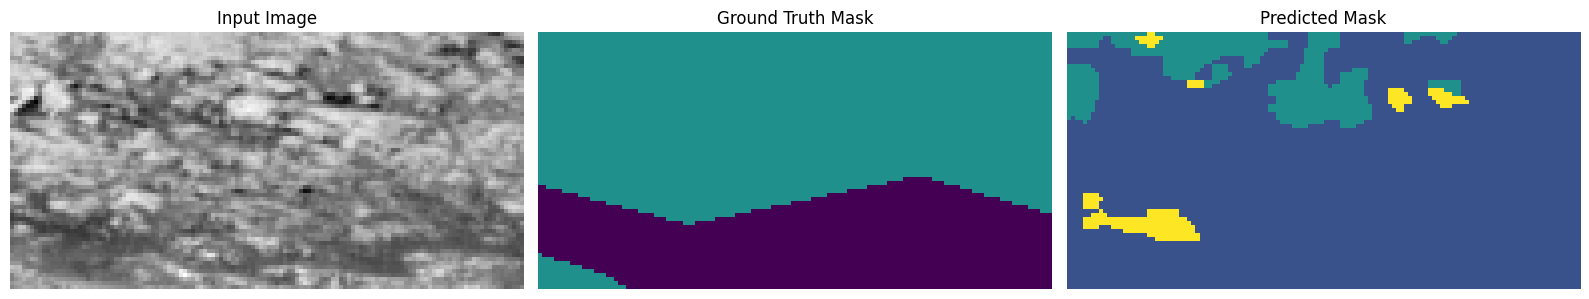

112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 390ms/step - accuracy: 0.5648 - loss: 1.0773 - mean_iou: 0.5432 - val_accuracy: 0.4679 - val_loss: 1.2636 - val_mean_iou: 0.3355
Epoch 42/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 382ms/step - accuracy: 0.5796 - loss: 1.0633 - mean_iou: 0.5635 - val_accuracy: 0.3873 - val_loss: 1.2857 - val_mean_iou: 0.2105
Epoch 43/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 382ms/step - accuracy: 0.5779 - loss: 1.0681 - mean_iou: 0.5582 - val_accuracy: 0.4289 - val_loss: 1.2305 - val_mean_iou: 0.2671
Epoch 44/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 381ms/step - accuracy: 0.5730 - loss: 1.0660 - mean_iou: 0.5580 - val_accuracy: 0.4406 - val_loss: 1.3312 - val_mean_iou: 0.2816
Epoch 45/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 382ms/step - accuracy: 0.5776 - loss: 1.0621 - mean_iou: 0.5632 - val_accuracy: 0.4331 - val_loss: 1.2812 - val_mean_iou: 0.3091
Epoch 46/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5662 - loss: 1.0723 - mean_iou: 0.5447

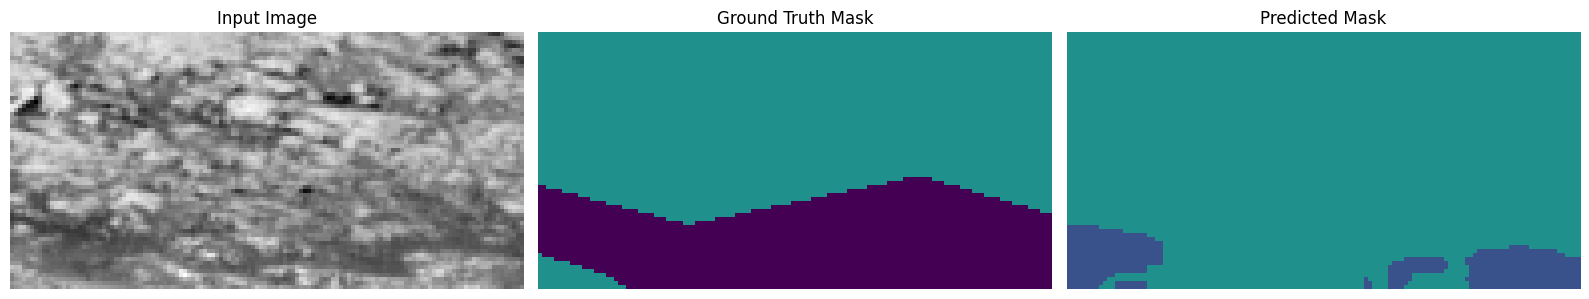

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 385ms/step - accuracy: 0.5659 - loss: 1.0722 - mean_iou: 0.5456 - val_accuracy: 0.5122 - val_loss: 1.1738 - val_mean_iou: 0.3760
Epoch 47/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 379ms/step - accuracy: 0.5693 - loss: 1.0725 - mean_iou: 0.5476 - val_accuracy: 0.4229 - val_loss: 1.2088 - val_mean_iou: 0.2612
Epoch 48/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 379ms/step - accuracy: 0.5664 - loss: 1.0727 - mean_iou: 0.5444 - val_accuracy: 0.3991 - val_loss: 1.2879 - val_mean_iou: 0.2258
Epoch 49/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 380ms/step - accuracy: 0.5872 - loss: 1.0524 - mean_iou: 0.5844 - val_accuracy: 0.5178 - val_loss: 1.1356 - val_mean_iou: 0.3923
Epoch 50/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 378ms/step - accuracy: 0.5841 - loss: 1.0571 - mean_iou: 0.5782 - val_accuracy: 0.5060 - val_loss: 1.1821 - val_mean_iou: 0.3954
Epoch 51/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.5924 - loss: 1.0472 - mean_iou: 0.5954

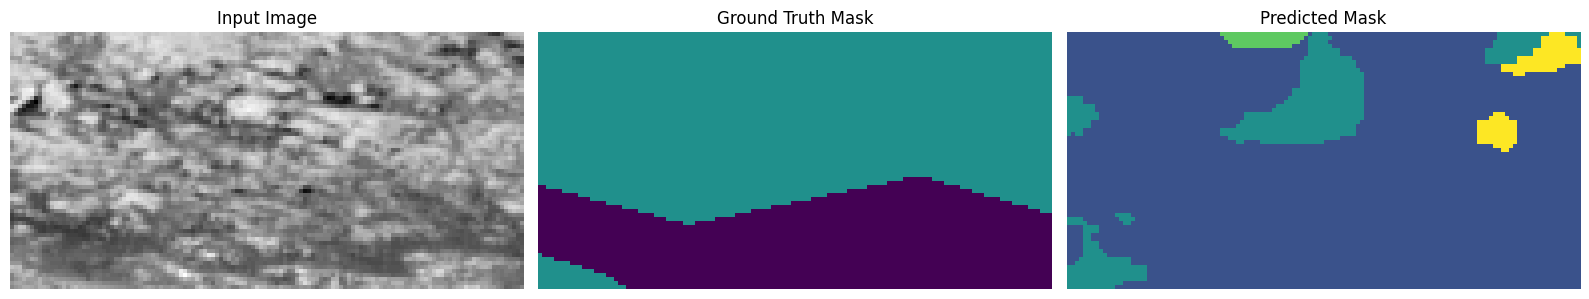

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 384ms/step - accuracy: 0.5919 - loss: 1.0471 - mean_iou: 0.5962 - val_accuracy: 0.5373 - val_loss: 1.1402 - val_mean_iou: 0.4239
Epoch 52/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 377ms/step - accuracy: 0.5847 - loss: 1.0546 - mean_iou: 0.5793 - val_accuracy: 0.4881 - val_loss: 1.2142 - val_mean_iou: 0.3506
Epoch 53/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 380ms/step - accuracy: 0.5818 - loss: 1.0561 - mean_iou: 0.5741 - val_accuracy: 0.5904 - val_loss: 1.0955 - val_mean_iou: 0.4982
Epoch 54/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 378ms/step - accuracy: 0.5814 - loss: 1.0582 - mean_iou: 0.5772 - val_accuracy: 0.5273 - val_loss: 1.1310 - val_mean_iou: 0.4107
Epoch 55/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 380ms/step - accuracy: 0.5820 - loss: 1.0577 - mean_iou: 0.5799 - val_accuracy: 0.5237 - val_loss: 1.1447 - val_mean_iou: 0.3987
Epoch 56/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.5886 - loss: 1.0503 - mean_iou: 0.5841

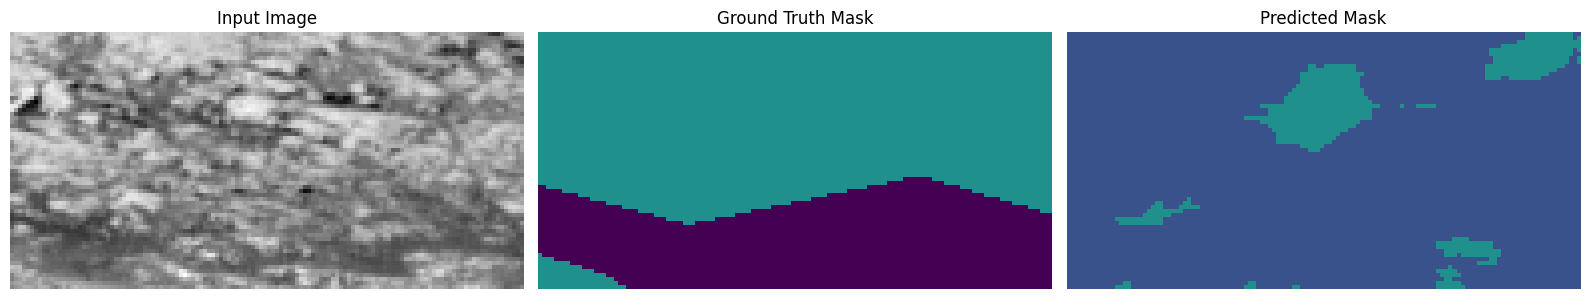

112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 384ms/step - accuracy: 0.5882 - loss: 1.0502 - mean_iou: 0.5849 - val_accuracy: 0.4954 - val_loss: 1.2006 - val_mean_iou: 0.3664
Epoch 57/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 379ms/step - accuracy: 0.5857 - loss: 1.0568 - mean_iou: 0.5872 - val_accuracy: 0.5481 - val_loss: 1.1484 - val_mean_iou: 0.4408
Epoch 58/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 378ms/step - accuracy: 0.5870 - loss: 1.0509 - mean_iou: 0.5944 - val_accuracy: 0.5376 - val_loss: 1.1266 - val_mean_iou: 0.4159
Epoch 59/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 382ms/step - accuracy: 0.5867 - loss: 1.0517 - mean_iou: 0.5907 - val_accuracy: 0.5021 - val_loss: 1.2017 - val_mean_iou: 0.3746
Epoch 60/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 380ms/step - accuracy: 0.5898 - loss: 1.0490 - mean_iou: 0.5931 - val_accuracy: 0.5311 - val_loss: 1.1334 - val_mean_iou: 0.4155
Epoch 61/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5867 - loss: 1.0560 - mean_iou: 0.5877

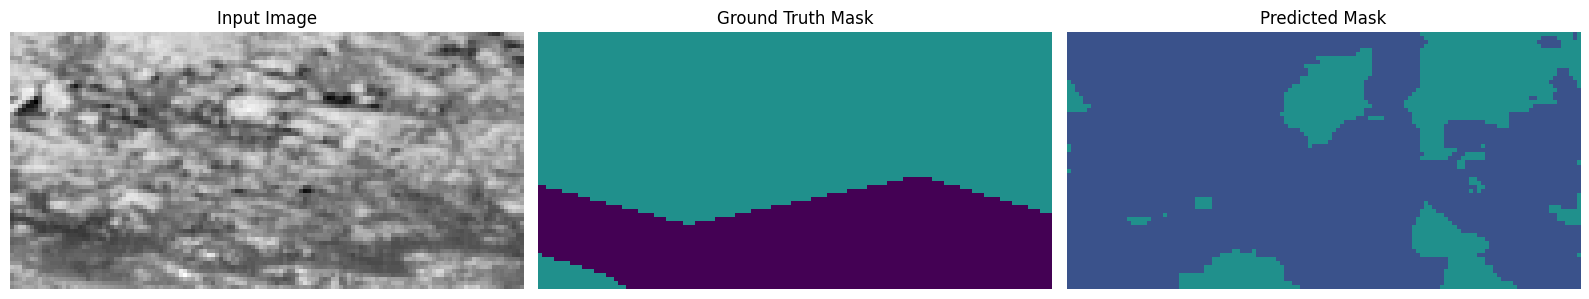

112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 386ms/step - accuracy: 0.5863 - loss: 1.0558 - mean_iou: 0.5885 - val_accuracy: 0.5466 - val_loss: 1.1585 - val_mean_iou: 0.4423
Epoch 62/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 381ms/step - accuracy: 0.5964 - loss: 1.0429 - mean_iou: 0.6129 - val_accuracy: 0.5577 - val_loss: 1.1247 - val_mean_iou: 0.4518
Epoch 63/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 380ms/step - accuracy: 0.5921 - loss: 1.0460 - mean_iou: 0.6004 - val_accuracy: 0.5232 - val_loss: 1.1665 - val_mean_iou: 0.4055
Epoch 64/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 381ms/step - accuracy: 0.5931 - loss: 1.0482 - mean_iou: 0.6030 - val_accuracy: 0.4561 - val_loss: 1.2770 - val_mean_iou: 0.3029
Epoch 65/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 380ms/step - accuracy: 0.5894 - loss: 1.0473 - mean_iou: 0.5980 - val_accuracy: 0.5189 - val_loss: 1.1516 - val_mean_iou: 0.4005
Epoch 66/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5879 - loss: 1.0481 - mean_iou: 0.5886

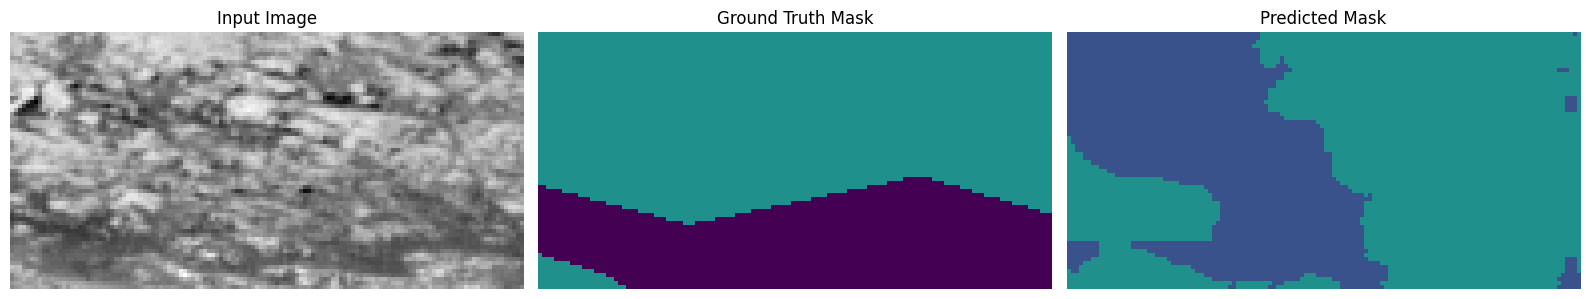

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 385ms/step - accuracy: 0.5875 - loss: 1.0480 - mean_iou: 0.5894 - val_accuracy: 0.5460 - val_loss: 1.0983 - val_mean_iou: 0.4352
Epoch 67/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 381ms/step - accuracy: 0.5919 - loss: 1.0486 - mean_iou: 0.5957 - val_accuracy: 0.5024 - val_loss: 1.1654 - val_mean_iou: 0.3884
Epoch 68/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 382ms/step - accuracy: 0.5896 - loss: 1.0486 - mean_iou: 0.5945 - val_accuracy: 0.5215 - val_loss: 1.1873 - val_mean_iou: 0.3928
Epoch 69/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 379ms/step - accuracy: 0.5914 - loss: 1.0456 - mean_iou: 0.5993 - val_accuracy: 0.5061 - val_loss: 1.1843 - val_mean_iou: 0.3922
Epoch 70/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 381ms/step - accuracy: 0.5931 - loss: 1.0461 - mean_iou: 0.6072 - val_accuracy: 0.5771 - val_loss: 1.0960 - val_mean_iou: 0.4768
Epoch 71/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.5895 - loss: 1.0488 - mean_iou: 0.5970

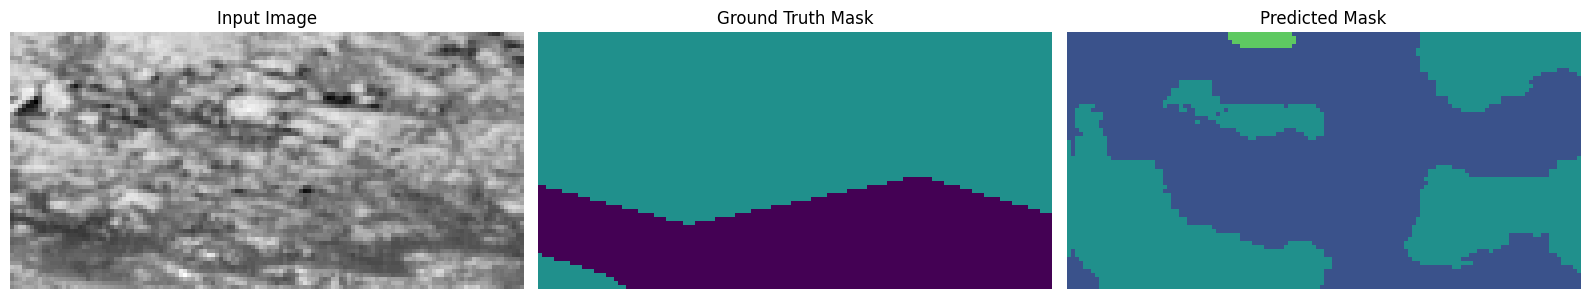

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 383ms/step - accuracy: 0.5891 - loss: 1.0486 - mean_iou: 0.5978 - val_accuracy: 0.5167 - val_loss: 1.1752 - val_mean_iou: 0.3975
Epoch 72/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 380ms/step - accuracy: 0.5944 - loss: 1.0467 - mean_iou: 0.5972 - val_accuracy: 0.5784 - val_loss: 1.1344 - val_mean_iou: 0.4766
Epoch 73/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 381ms/step - accuracy: 0.5917 - loss: 1.0478 - mean_iou: 0.5866 - val_accuracy: 0.5255 - val_loss: 1.1449 - val_mean_iou: 0.4084
Epoch 74/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 380ms/step - accuracy: 0.5948 - loss: 1.0418 - mean_iou: 0.5908 - val_accuracy: 0.5631 - val_loss: 1.1187 - val_mean_iou: 0.4648
Epoch 75/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 393ms/step - accuracy: 0.5908 - loss: 1.0469 - mean_iou: 0.5958 - val_accuracy: 0.1945 - val_loss: 1.5582 - val_mean_iou: 0.1416
Epoch 76/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6004 - loss: 1.0381 - mean_iou: 0.6080

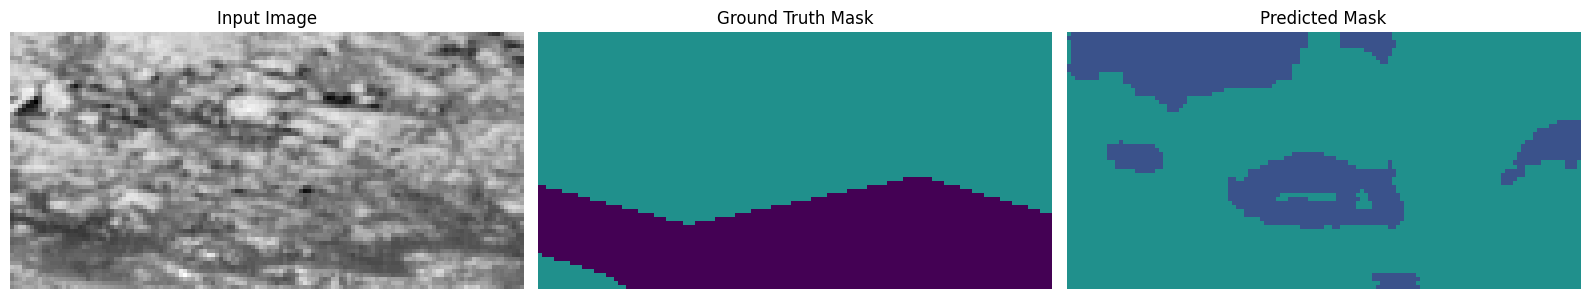

112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 382ms/step - accuracy: 0.5999 - loss: 1.0381 - mean_iou: 0.6087 - val_accuracy: 0.5525 - val_loss: 1.1194 - val_mean_iou: 0.4407
Epoch 77/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 380ms/step - accuracy: 0.5957 - loss: 1.0394 - mean_iou: 0.6077 - val_accuracy: 0.5980 - val_loss: 1.0667 - val_mean_iou: 0.5211
Epoch 78/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 384ms/step - accuracy: 0.5923 - loss: 1.0492 - mean_iou: 0.6028 - val_accuracy: 0.5813 - val_loss: 1.0711 - val_mean_iou: 0.4792
Epoch 79/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 378ms/step - accuracy: 0.5914 - loss: 1.0458 - mean_iou: 0.6076 - val_accuracy: 0.5766 - val_loss: 1.0823 - val_mean_iou: 0.4874
Epoch 80/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 385ms/step - accuracy: 0.5999 - loss: 1.0391 - mean_iou: 0.6104 - val_accuracy: 0.6277 - val_loss: 1.0410 - val_mean_iou: 0.5679
Epoch 81/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5901 - loss: 1.0486 - mean_iou: 0.5942

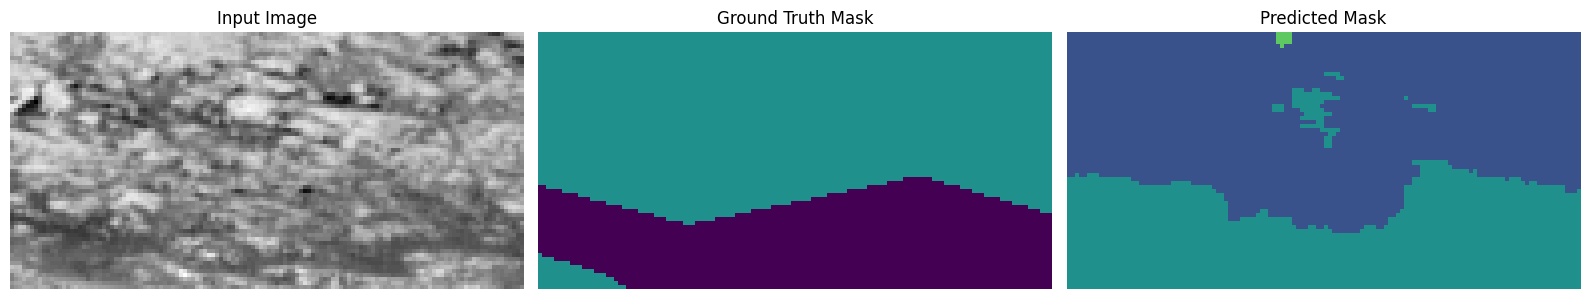

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 386ms/step - accuracy: 0.5896 - loss: 1.0485 - mean_iou: 0.5950 - val_accuracy: 0.5659 - val_loss: 1.1062 - val_mean_iou: 0.4635
Epoch 82/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 381ms/step - accuracy: 0.5884 - loss: 1.0482 - mean_iou: 0.5903 - val_accuracy: 0.5345 - val_loss: 1.1513 - val_mean_iou: 0.4261
Epoch 83/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 380ms/step - accuracy: 0.5962 - loss: 1.0420 - mean_iou: 0.6106 - val_accuracy: 0.4786 - val_loss: 1.1745 - val_mean_iou: 0.3429
Epoch 84/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 378ms/step - accuracy: 0.5988 - loss: 1.0401 - mean_iou: 0.6003 - val_accuracy: 0.5299 - val_loss: 1.1189 - val_mean_iou: 0.4127
Epoch 85/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 377ms/step - accuracy: 0.5963 - loss: 1.0409 - mean_iou: 0.6104 - val_accuracy: 0.4895 - val_loss: 1.2005 - val_mean_iou: 0.3819
Epoch 86/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.5974 - loss: 1.0376 - mean_iou: 0.6184

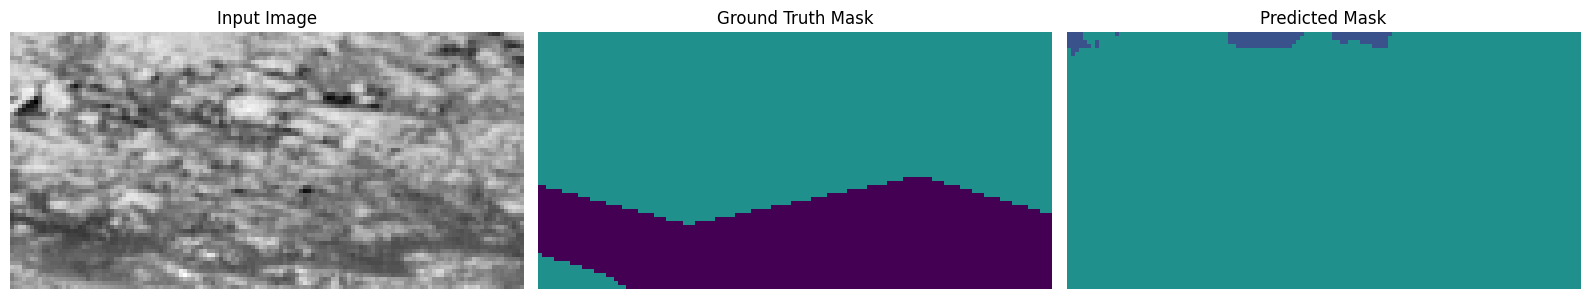

112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 383ms/step - accuracy: 0.5970 - loss: 1.0375 - mean_iou: 0.6192 - val_accuracy: 0.5974 - val_loss: 1.0706 - val_mean_iou: 0.5213
Epoch 87/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 382ms/step - accuracy: 0.5950 - loss: 1.0407 - mean_iou: 0.6001 - val_accuracy: 0.5415 - val_loss: 1.1292 - val_mean_iou: 0.4180
Epoch 88/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 375ms/step - accuracy: 0.6010 - loss: 1.0379 - mean_iou: 0.6154 - val_accuracy: 0.6304 - val_loss: 1.0536 - val_mean_iou: 0.5593
Epoch 89/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 380ms/step - accuracy: 0.5995 - loss: 1.0385 - mean_iou: 0.6147 - val_accuracy: 0.5620 - val_loss: 1.1238 - val_mean_iou: 0.4422
Epoch 90/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 374ms/step - accuracy: 0.5955 - loss: 1.0386 - mean_iou: 0.6169 - val_accuracy: 0.5908 - val_loss: 1.0828 - val_mean_iou: 0.4897
Epoch 91/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.5868 - loss: 1.0530 - mean_iou: 0.5884

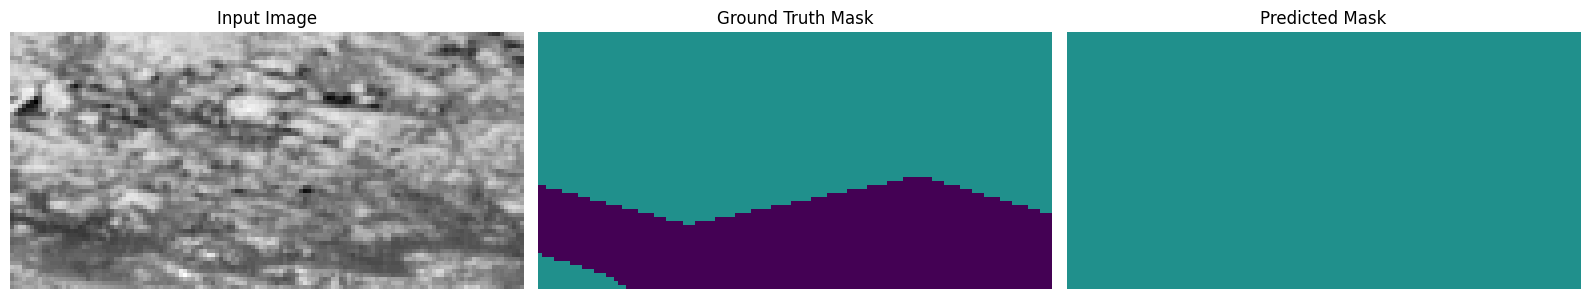

112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 382ms/step - accuracy: 0.5864 - loss: 1.0529 - mean_iou: 0.5892 - val_accuracy: 0.6290 - val_loss: 1.0405 - val_mean_iou: 0.5632
Epoch 92/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 382ms/step - accuracy: 0.5998 - loss: 1.0359 - mean_iou: 0.6179 - val_accuracy: 0.4797 - val_loss: 1.2155 - val_mean_iou: 0.3482
Epoch 93/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 378ms/step - accuracy: 0.5952 - loss: 1.0417 - mean_iou: 0.6202 - val_accuracy: 0.5085 - val_loss: 1.1397 - val_mean_iou: 0.3670
Epoch 94/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 375ms/step - accuracy: 0.5988 - loss: 1.0369 - mean_iou: 0.6207 - val_accuracy: 0.5260 - val_loss: 1.1701 - val_mean_iou: 0.4119
Epoch 95/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 381ms/step - accuracy: 0.5978 - loss: 1.0399 - mean_iou: 0.6128 - val_accuracy: 0.5893 - val_loss: 1.0816 - val_mean_iou: 0.4900
Epoch 96/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.6066 - loss: 1.0314 - mean_iou: 0.6282

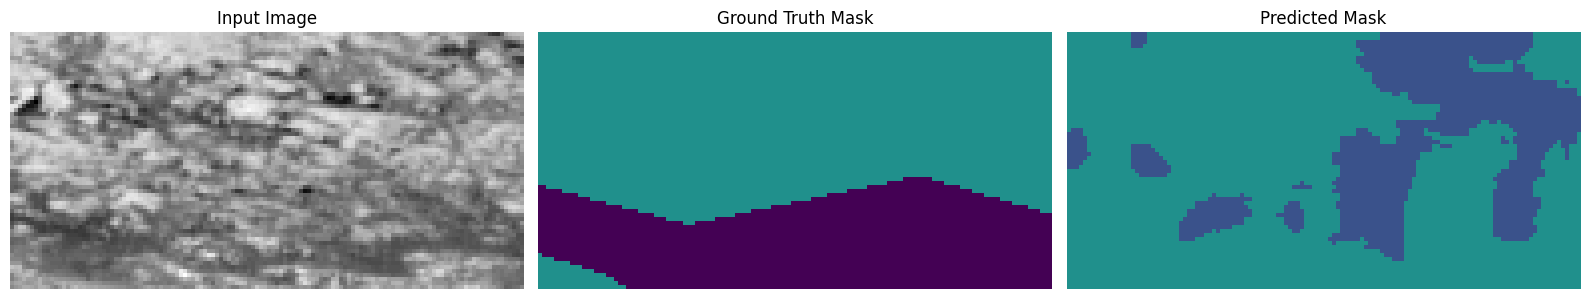

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 382ms/step - accuracy: 0.6061 - loss: 1.0312 - mean_iou: 0.6290 - val_accuracy: 0.5524 - val_loss: 1.1256 - val_mean_iou: 0.4497
Epoch 97/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 374ms/step - accuracy: 0.6040 - loss: 1.0340 - mean_iou: 0.6232 - val_accuracy: 0.5774 - val_loss: 1.0939 - val_mean_iou: 0.4758
Epoch 98/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 381ms/step - accuracy: 0.6010 - loss: 1.0371 - mean_iou: 0.6226 - val_accuracy: 0.5725 - val_loss: 1.1003 - val_mean_iou: 0.4739
Epoch 99/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 379ms/step - accuracy: 0.6027 - loss: 1.0344 - mean_iou: 0.6207 - val_accuracy: 0.5210 - val_loss: 1.1464 - val_mean_iou: 0.4093
Epoch 100/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 377ms/step - accuracy: 0.5961 - loss: 1.0410 - mean_iou: 0.6130 - val_accuracy: 0.5819 - val_loss: 1.0931 - val_mean_iou: 0.5048
Epoch 101/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6012 - loss: 1.0372 - mean_iou: 0.6159

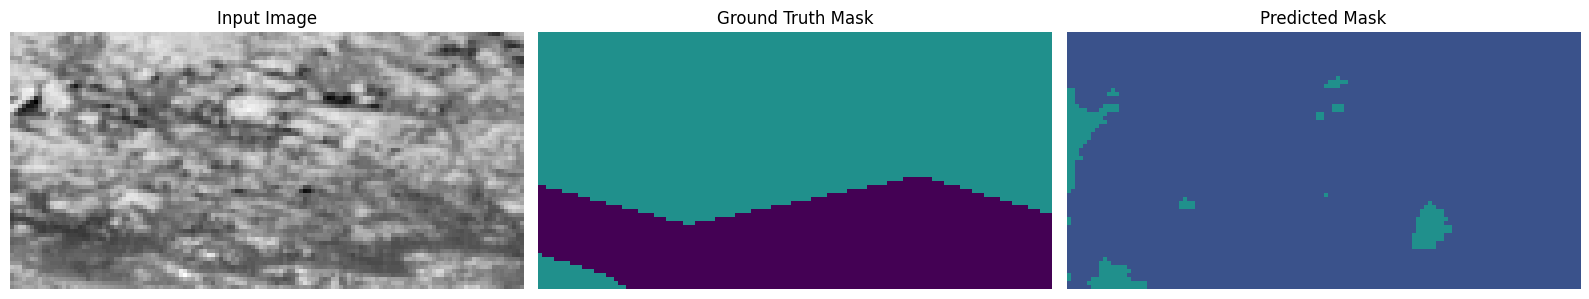

112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 381ms/step - accuracy: 0.6008 - loss: 1.0371 - mean_iou: 0.6168 - val_accuracy: 0.5327 - val_loss: 1.1211 - val_mean_iou: 0.4252
Epoch 102/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 375ms/step - accuracy: 0.6057 - loss: 1.0317 - mean_iou: 0.6357 - val_accuracy: 0.5158 - val_loss: 1.1602 - val_mean_iou: 0.3958
Epoch 103/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 379ms/step - accuracy: 0.6032 - loss: 1.0355 - mean_iou: 0.6181 - val_accuracy: 0.4905 - val_loss: 1.2060 - val_mean_iou: 0.3729
Epoch 104/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 375ms/step - accuracy: 0.6095 - loss: 1.0283 - mean_iou: 0.6310 - val_accuracy: 0.4936 - val_loss: 1.1564 - val_mean_iou: 0.3593
Epoch 105/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 383ms/step - accuracy: 0.5965 - loss: 1.0413 - mean_iou: 0.5877 - val_accuracy: 0.5514 - val_loss: 1.1281 - val_mean_iou: 0.4542
Epoch 106/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6033 - loss: 1.0357 - mean_iou: 0.6203

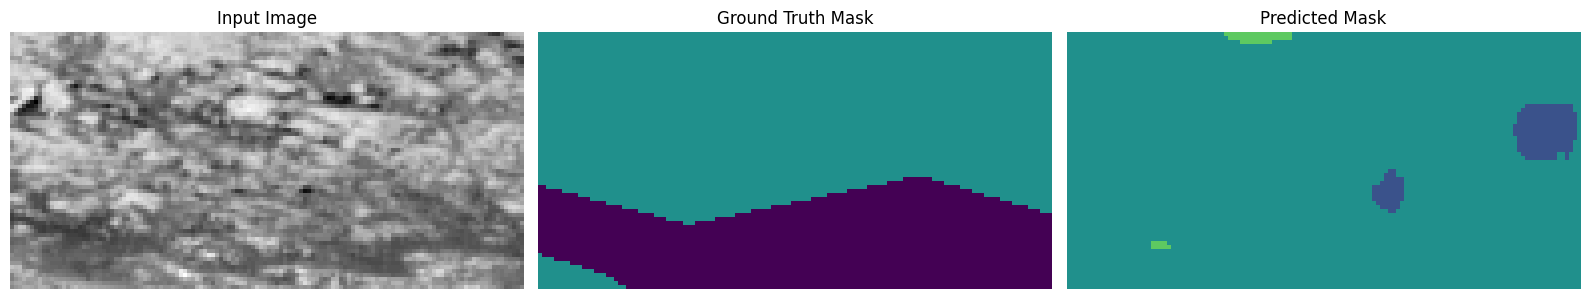

112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 380ms/step - accuracy: 0.6029 - loss: 1.0356 - mean_iou: 0.6211 - val_accuracy: 0.5997 - val_loss: 1.0814 - val_mean_iou: 0.5125
Epoch 107/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 377ms/step - accuracy: 0.6011 - loss: 1.0366 - mean_iou: 0.6169 - val_accuracy: 0.5295 - val_loss: 1.1289 - val_mean_iou: 0.4403
Epoch 108/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 376ms/step - accuracy: 0.6093 - loss: 1.0292 - mean_iou: 0.6307 - val_accuracy: 0.5836 - val_loss: 1.1068 - val_mean_iou: 0.4818
Epoch 109/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 374ms/step - accuracy: 0.6005 - loss: 1.0380 - mean_iou: 0.6120 - val_accuracy: 0.4598 - val_loss: 1.2418 - val_mean_iou: 0.3158
Epoch 110/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 377ms/step - accuracy: 0.6015 - loss: 1.0350 - mean_iou: 0.6242 - val_accuracy: 0.5228 - val_loss: 1.1516 - val_mean_iou: 0.4289
Epoch 111/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.6054 - loss: 1.0310 - mean_iou: 0.6286

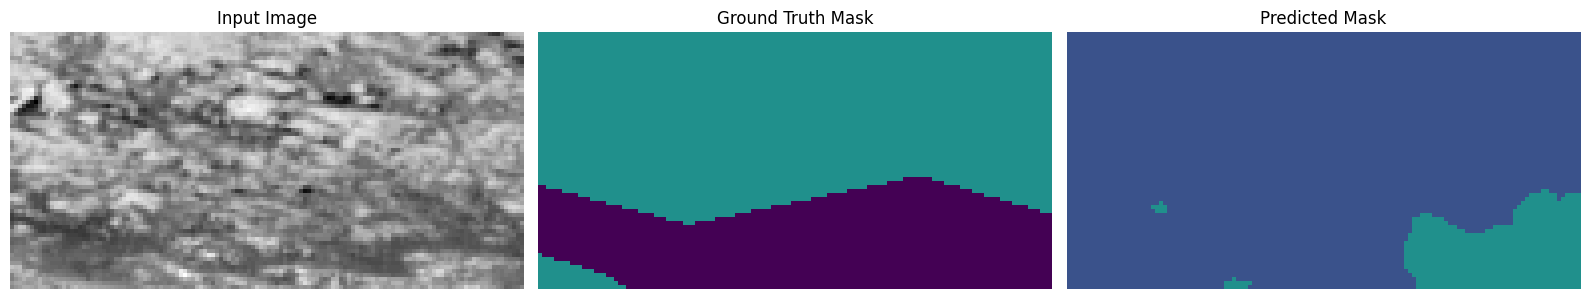

112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 385ms/step - accuracy: 0.6049 - loss: 1.0309 - mean_iou: 0.6293 - val_accuracy: 0.5160 - val_loss: 1.1740 - val_mean_iou: 0.4118
Epoch 112/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 377ms/step - accuracy: 0.6009 - loss: 1.0360 - mean_iou: 0.6182 - val_accuracy: 0.5299 - val_loss: 1.1729 - val_mean_iou: 0.4034
Epoch 113/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 376ms/step - accuracy: 0.6062 - loss: 1.0310 - mean_iou: 0.6305 - val_accuracy: 0.5204 - val_loss: 1.1620 - val_mean_iou: 0.4141
Epoch 114/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 379ms/step - accuracy: 0.6028 - loss: 1.0327 - mean_iou: 0.6289 - val_accuracy: 0.5908 - val_loss: 1.0852 - val_mean_iou: 0.5097
Epoch 115/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 377ms/step - accuracy: 0.5979 - loss: 1.0406 - mean_iou: 0.6248 - val_accuracy: 0.5081 - val_loss: 1.1861 - val_mean_iou: 0.3865
Epoch 116/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6003 - loss: 1.0394 - mean_iou: 0.6187

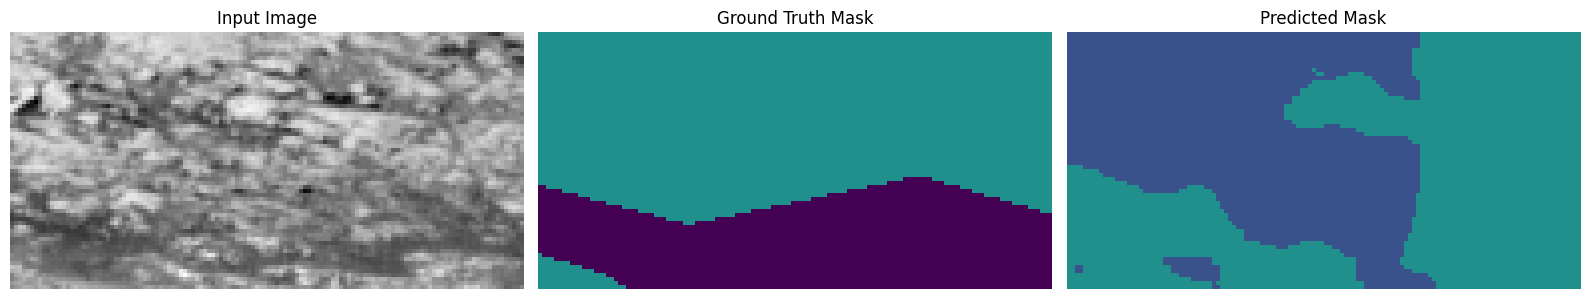

112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 381ms/step - accuracy: 0.5999 - loss: 1.0392 - mean_iou: 0.6195 - val_accuracy: 0.5362 - val_loss: 1.1535 - val_mean_iou: 0.4324
Epoch 117/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 376ms/step - accuracy: 0.6077 - loss: 1.0274 - mean_iou: 0.6385 - val_accuracy: 0.5269 - val_loss: 1.1462 - val_mean_iou: 0.4027
Epoch 118/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 376ms/step - accuracy: 0.6045 - loss: 1.0306 - mean_iou: 0.6325 - val_accuracy: 0.6201 - val_loss: 1.0556 - val_mean_iou: 0.5531
Epoch 119/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 376ms/step - accuracy: 0.6111 - loss: 1.0264 - mean_iou: 0.6406 - val_accuracy: 0.6167 - val_loss: 1.0557 - val_mean_iou: 0.5608
Epoch 120/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 377ms/step - accuracy: 0.6087 - loss: 1.0289 - mean_iou: 0.6287 - val_accuracy: 0.5817 - val_loss: 1.1199 - val_mean_iou: 0.5061
Epoch 121/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.6042 - loss: 1.0354 - mean_iou: 0.6198

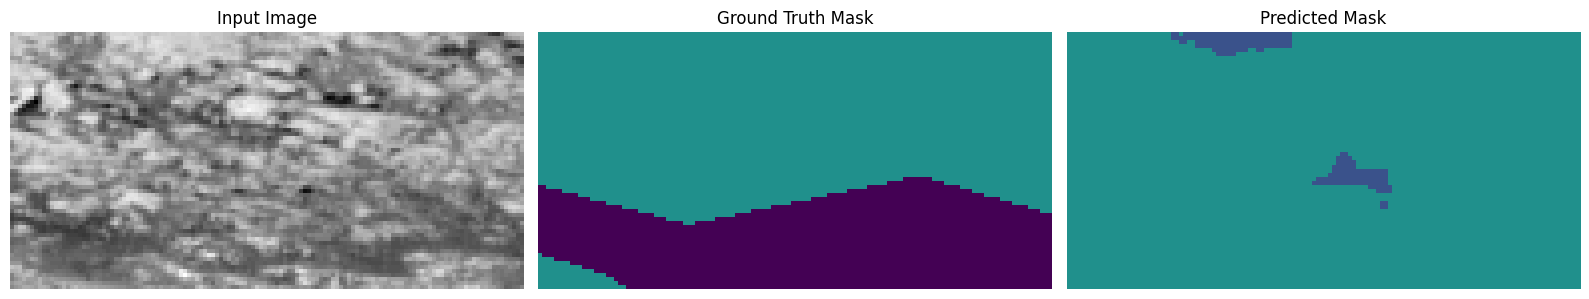

112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 384ms/step - accuracy: 0.6038 - loss: 1.0352 - mean_iou: 0.6207 - val_accuracy: 0.6040 - val_loss: 1.0704 - val_mean_iou: 0.5161
Epoch 122/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 374ms/step - accuracy: 0.6067 - loss: 1.0312 - mean_iou: 0.6384 - val_accuracy: 0.6020 - val_loss: 1.0760 - val_mean_iou: 0.5379
Epoch 123/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 377ms/step - accuracy: 0.6056 - loss: 1.0300 - mean_iou: 0.6293 - val_accuracy: 0.5536 - val_loss: 1.1350 - val_mean_iou: 0.4529
Epoch 124/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 381ms/step - accuracy: 0.6076 - loss: 1.0271 - mean_iou: 0.6362 - val_accuracy: 0.4998 - val_loss: 1.2074 - val_mean_iou: 0.3759
Epoch 125/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 377ms/step - accuracy: 0.5986 - loss: 1.0387 - mean_iou: 0.6054 - val_accuracy: 0.5408 - val_loss: 1.1751 - val_mean_iou: 0.4282
Epoch 126/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.5763 - loss: 1.0746 - mean_iou: 0.5226

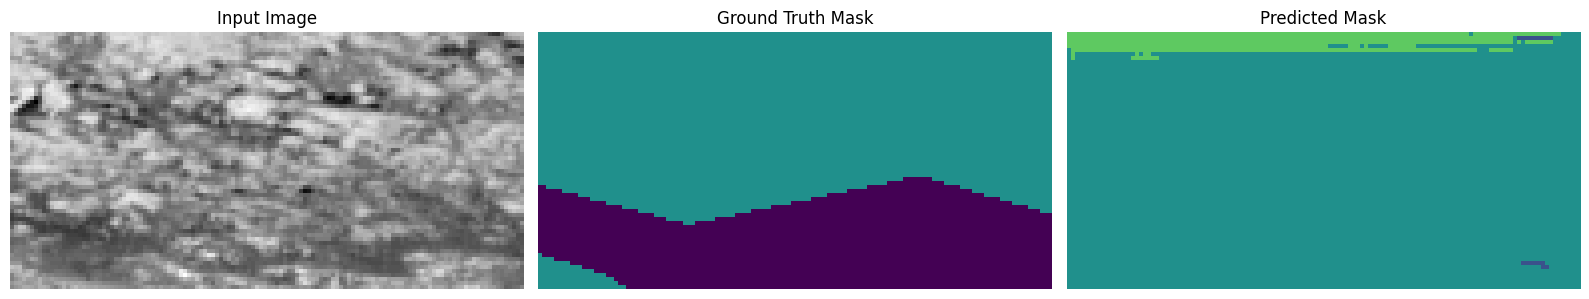

112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 384ms/step - accuracy: 0.5755 - loss: 1.0750 - mean_iou: 0.5222 - val_accuracy: 0.2345 - val_loss: 1.4051 - val_mean_iou: 0.0943
Epoch 127/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 373ms/step - accuracy: 0.4598 - loss: 1.1887 - mean_iou: 0.3614 - val_accuracy: 0.3507 - val_loss: 1.4123 - val_mean_iou: 0.1433
Epoch 128/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 381ms/step - accuracy: 0.5218 - loss: 1.1257 - mean_iou: 0.4356 - val_accuracy: 0.4567 - val_loss: 1.2635 - val_mean_iou: 0.3013
Epoch 129/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 376ms/step - accuracy: 0.5306 - loss: 1.1192 - mean_iou: 0.4463 - val_accuracy: 0.4310 - val_loss: 1.2608 - val_mean_iou: 0.2720
Epoch 130/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 377ms/step - accuracy: 0.5361 - loss: 1.1118 - mean_iou: 0.4652 - val_accuracy: 0.3877 - val_loss: 1.3599 - val_mean_iou: 0.2406
Final validation Mean Intersection Over Union: 56.79%


NotImplementedError: Learning rate schedule 'WarmUpCosineDecay' must override `get_config()` in order to be serializable.

In [33]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
# del model

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
# if "model_filename" not in globals() or model_filename is None:
#     files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
#     files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
#     if files:
#         model_filename = files[0]
#     else:
#         raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
# model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

In [ ]:
preds = model.predict(test_dataset)
predicted_classes = np.argmax(preds, axis=-1)
print(preds.shape)
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes
preds = np.argmax(preds, axis=-1)
#print(test_lbl[0])
print(f"Predictions shape: {preds.shape}")
#accuracy
#show predictions ....
colormap = create_segmentation_colormap(num_classes)
for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  colored_label = apply_colormap(preds[i], colormap)
  colored_truth = apply_colormap(test_lbl[i], colormap)

  # Prediction
  axes[0].imshow(colored_label)
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(test_img[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  # Ground truth label
  axes[2].imshow(colored_truth)
  axes[2].set_title("Ground Truth")
  axes[2].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


In [ ]:
preds = model.predict(X_test)
predicted_classes = np.argmax(preds, axis=-1)
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes
preds = np.argmax(preds, axis=-1)

for i in range(10):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Create a figure with 3 subplots

  colored_label = apply_colormap(preds[i], colormap)

  # Prediction
  axes[0].imshow(colored_label)
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(X_test[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
print(submission_filename)
from google.colab import files
files.download(submission_filename)

In [ ]:
#nr of rows
print(submission_df.shape)

In [ ]:
# disconnect
from google.colab import runtime
runtime.unassign()


#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```